### MODEL AVEC INCEPTIONV3

#### 1) Contexte

InceptionV3 est une architecture de réseau de neurones convolutifs(CNN) développée par Google, introduite dans l'article : "Rethinking the Inception Architecture for Computer Vision" en 2015.
C'est une amélioration des anciennes versions Inception, avec des améliorations significatives en termes de performance et d'éfficacité computationnelle.
InceptionV3 est un modéle pré-entrainée sur le dataset ImageNet, qui contient plus d'1 million d'images et 1000 classes.

#### 2) Concept principal de Inception

Les modules Inception permettent de capturer à la fois des caractéristique générales et locales dans une image. Cela est possible en partie grâce à la combinaison de plusieurs convolutions de différentes tailles de noyaux dans une même couche:

 - Convolution 1x1 qui permet de réduire le nombre de canaux et d'extraire des caractéristiques fines
 - Convolutions 3x3 et 5x5  qui permet de capturer des motifs locaux plus généraux et plus complexes
 - Pooling qui permet de réduire la résolution et extraire des informations invariantes aux translations

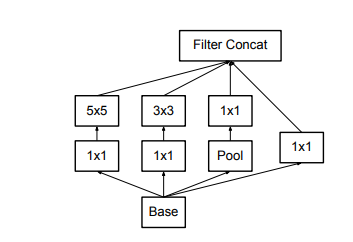

#### 3) Ses améliorations

Ce modéle présente plusieurs améliorations par rapport aux versions antérieur:

 - Les convolutions de grande taille (par ex., 5x5) sont remplacées par une séquence de convolutions plus petites (par ex., deux convolutions 3x3). Cela réduit le coût computationnel tout en préservant la capacité à capturer des motifs complexes.
 - L'intégration dans plusieurs couches de la batch normalisation pour accélérer la convergence et stabiliser l'apprentissage
 - Des prédicteurs auxiliaires sont utilisés à des étapes intermédiaires pour améliorer la rétropropagation des gradients (observable plutôt vers la fin de l'entraînement) et réduire le risque de surapprentissage

Observons le tableau suivant:

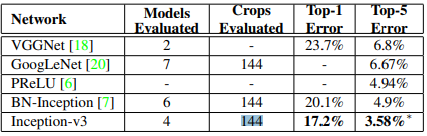

InceptionV3 affiche des performances avec un taux d’erreur Top-1 de 17.2 % et Top-5 de 3.58 %, surpassant VGGNet (23.7 % et 6.8 %) et GoogLeNet (6.67 % en Top-5). Sa faible erreur Top-5 démontre sa capacité à identifier avec précision les classes dans un ensemble de données large et diversifié comme ImageNet. Cela en fait un modèle de référence pour la classification d’images.

#### 4) Structure globale

L’architecture InceptionV3 comprend environ 24 millions de paramètres répartis en plusieurs blocs. Elle peut être divisée en trois grandes parties :

 - Extraction des caractéristiques de bas niveau : Les premières couches extraient des caractéristiques simples à partir des pixels bruts.
 - Extraction des caractéristiques complexes : Les modules Inception permettent d'extraire des motifs de plus en plus complexes et invariants, grâce à des convolutions à différentes échelles.
 - Classification finale : Une couche GlobalAveragePooling suit les blocs convolutifs, compressant l’information en un vecteur de caractéristiques. Ce vecteur est ensuite transmis à des couches denses pour effectuer la classification finale.


###### source : https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf

## Données

In [1]:
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt 
import os


In [2]:
import preprocessing

Nombre d'images dans chaque classe d'entraînement :
resized_glioma_tumor_256 : 661 images
resized_meningioma_tumor_256 : 658 images
resized_no_tumor_256 : 316 images
resized_pituitary_tumor_256 : 662 images

Nombre d'images dans chaque classe de validation :
resized_glioma_tumor_256 : 165 images
resized_meningioma_tumor_256 : 164 images
resized_no_tumor_256 : 79 images
resized_pituitary_tumor_256 : 165 images


In [3]:
from module_for_preprocessing import load_images_with_preprocessing

training = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Training")
validation = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Validation")

X_train, y_train= load_images_with_preprocessing(training, 256)

X_val, y_val= load_images_with_preprocessing(training, 256)


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(X_train))  
    .batch(batch_size)                  
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

val_dataset = (
    val_dataset
    .batch(batch_size)                 
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

In [5]:
def convert_to_rgb(image, label):
    # Duplique le canal unique 3 fois pour créer une image RGB
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_dataset = train_dataset.map(convert_to_rgb)
val_dataset=val_dataset.map(convert_to_rgb)

## Modéle 

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Charger le modèle de base InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Geler les couches de base
base_model.trainable = False

# Construire le modèle avec plus de couches et régularisation
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Nombre de classes
])

# Compiler le modèle
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement initial
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stop]
)

base_model.trainable = True
for layer in base_model.layers[:200]:  # Geler une plus grande partie des couches
    layer.trainable = False

# Recompiler avec un learning rate plus faible
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.4773 - loss: 6.6679 - val_accuracy: 0.4410 - val_loss: 4.5917 - learning_rate: 0.0010
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 372s 5s/step - accuracy: 0.6251 - loss: 3.8411 - val_accuracy: 0.6469 - val_loss: 2.9232 - learning_rate: 0.0010
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.6542 - loss: 2.8696 - val_accuracy: 0.6561 - val_loss: 2.4785 - learning_rate: 0.0010
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 367s 5s/step - accuracy: 0.6771 - loss: 2.4432 - val_accuracy: 0.6173 - val_loss: 2.4225 - learning_rate: 0.0010
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.6722 - loss: 2.1966 - val_accuracy: 0.4732 - val_loss: 2.6455 - learning_rate: 0.0010
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.6678 - loss: 1.9405 - val_accuracy: 0.5747 - val_loss: 2.3364 - learning_rate: 0.0010
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.6749 - loss: 1.8121 - val_acc

### Explication modéle

#### Paramètre utilisés:

 - weights='imagenet': on utilise les poids pré-appris sur ImageNet
 - include_top=False: on exclues les couches finales de classification du modéle pré-entrainé. le modéle ne produit plus de prédictions sur les classes d’ImageNet, mais seulement des cartes de caractéristiques extraites par les couches convolutives précédentes.

#### Couches ajoutées à la base inception

- GlobalAveragePooling2D : Comprime les caractéristiques spatiales extraites par InceptionV3 en un vecteur de caractéristiques globales pour chaque image.
- Dense (256 unités) : Une couche entièrement connectée avec une activation ReLU, introduisant de la non-linéarité pour apprendre des relations complexes entre les caractéristiques.
- Batch Normalization : Normalise les activations pour accélérer l’apprentissage et réduire les risques de divergence.
- Dropout (0.5) : Désactive aléatoirement 50 % des neurones lors de chaque itération pour limiter le sur-apprentissage.
- Dense (128 unités) : Une seconde couche dense avec la même configuration que la précédente, permettant d'affiner les représentations apprises.
- Dense (4 unités) : Une couche finale avec activation softmax, produisant des probabilités pour les 4 classes de tumeurs.

#### Callbacks pour l’entraînement

- ReduceLROnPlateau : Réduit le taux d’apprentissage lorsque la perte de validation ne diminue plus, pour permettre au modèle de faire de plus petits ajustements et continuer à s’améliorer.
- EarlyStopping : Arrête l’entraînement si la perte de validation ne s’améliore pas pendant 5 époques consécutives, permettant d’éviter un surapprentissage inutile.


#### Fine-tuning
Après l’entraînement initial des couches personnalisées, certaines couches de la base InceptionV3 sont dégelées pour ajuster leurs poids au dataset spécifique. Le fine-tuning est effectué avec :

- Déblocage partiel des couches : Les 200 premières couches d’InceptionV3 restent gelées pour conserver les caractéristiques générales, tandis que les couches plus profondes s’ajustent aux données spécifiques.
- Learning rate réduit (0.0001) : Pour éviter de perturber excessivement les poids pré-appris.

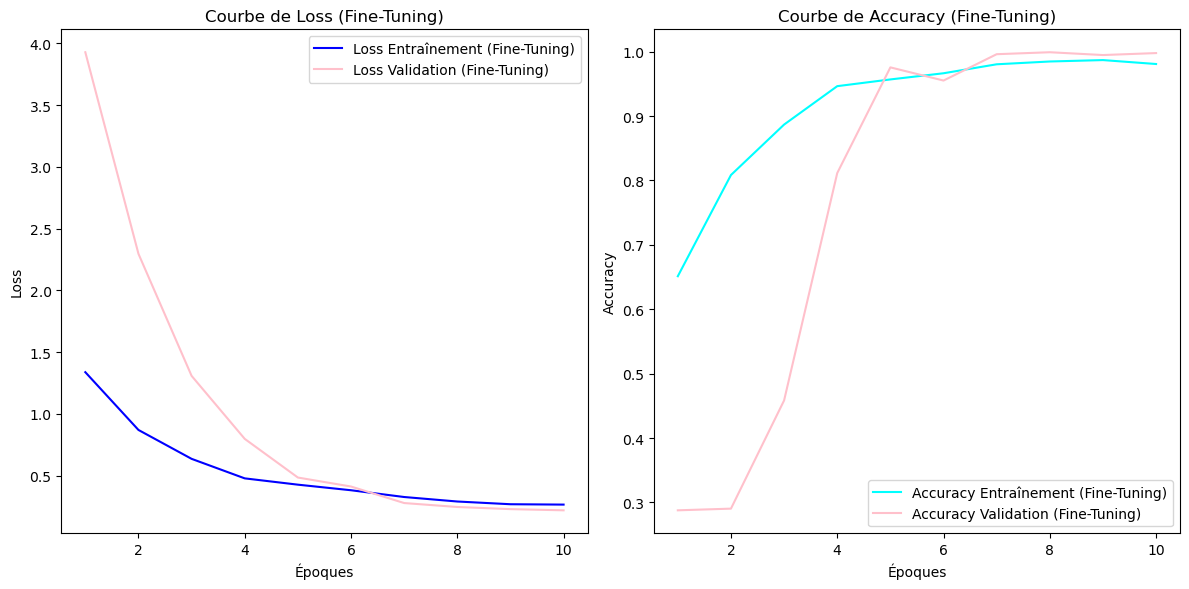

In [10]:
train_loss_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']
train_accuracy_fine = history_fine.history['accuracy']
val_accuracy_fine = history_fine.history['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_fine) + 1), train_loss_fine, label='Loss Entraînement (Fine-Tuning)', color='blue')
plt.plot(range(1, len(val_loss_fine) + 1), val_loss_fine, label='Loss Validation (Fine-Tuning)', color='pink')
plt.title('Courbe de Loss (Fine-Tuning)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy_fine) + 1), train_accuracy_fine, label='Accuracy Entraînement (Fine-Tuning)', color='cyan')
plt.plot(range(1, len(val_accuracy_fine) + 1), val_accuracy_fine, label='Accuracy Validation (Fine-Tuning)', color='pink')
plt.title('Courbe de Accuracy (Fine-Tuning)')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Interpretation courbe 

##### Perte (Loss) :
La perte d’entraînement décroît de manière régulière, passant d’environ 4.0 à moins de 0.5, ce qui reflète un ajustement efficace des paramètres du modèle aux données.La perte de validation suit une tendance similaire, convergeant vers une valeur proche de 0.5, ce qui indique une bonne généralisation sur l’ensemble de validation.

##### Accuracy :
L’exactitude d’entraînement atteint  98%, ce qui montre que le modèle est capable de s’adapter parfaitement aux données d’entraînement.
L’exactitude de validation augmente rapidement, dépassant 90 % après quelques époques et se stabilisant par la suite autour des 99% ce qui est un indicateur de bonnes performances générales sur des données inconnues.

Ces résultats indiquent que le modèle a réussi à tirer profit des caractéristiques pré-apprises d'InceptionV3 tout en s'adaptant efficacement à la tâche spécifique.


In [11]:
test = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "../..")), "archive","data","Testing")

X_test, y_test = load_images_with_preprocessing(test, 256)
print(f"Chargé {len(X_test)} images avec {len(y_test)} étiquettes.")

Chargé 394 images avec 394 étiquettes.


In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 32
test_dataset = (
    test_dataset
    .batch(batch_size)                  
    .prefetch(tf.data.experimental.AUTOTUNE)  # Optimisation de préchargement
)

test_dataset=test_dataset.map(convert_to_rgb)

loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 6s/step - accuracy: 0.5402 - loss: 2.1903
Loss: 1.4177871942520142
Accuracy: 0.7131979465484619


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Classe 'glioma_tumor': 25.00% de prédictions correctes, 75.00% de prédictions incorrectes
Classe 'pituitary_tumor': 93.04% de prédictions correctes, 6.96% de prédictions incorrectes
Classe 'no_tumor': 93.33% de prédictions correctes, 6.67% de prédictions incorrectes
Classe 'meningioma_tumor': 68.92% de prédictions correctes, 31.08% de prédictions incorrectes


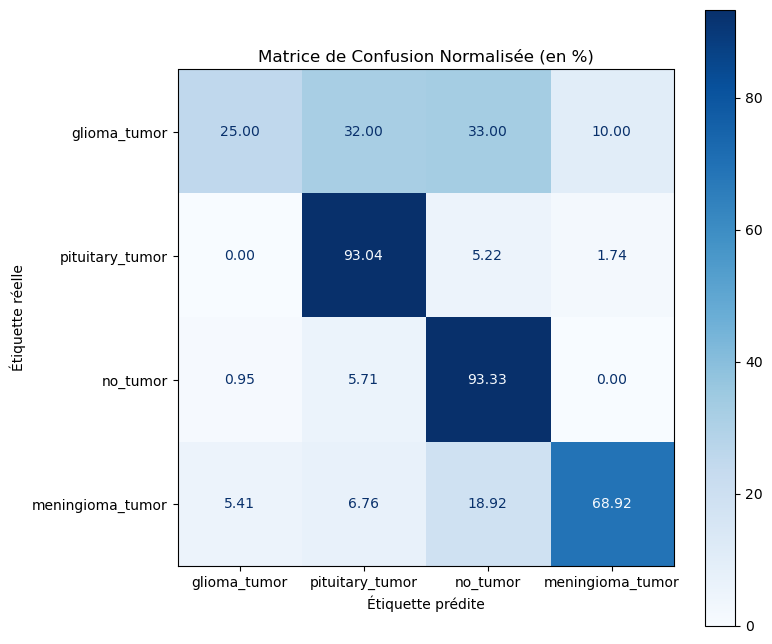

In [13]:
# Étape 1 : Extraire les vraies étiquettes et faire les prédictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Étape 2 : Calculer la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
class_names = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']

# Étape 3 : Normaliser la matrice pour obtenir les pourcentages par classe
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Pourcentage par ligne

# Étape 4 : Afficher la matrice de confusion avec les pourcentages
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Matrice de Confusion Normalisée (en %)")
plt.ylabel('Étiquette réelle')
plt.xlabel('Étiquette prédite')

# Étape 5 : Afficher les pourcentages de prédictions correctes et incorrectes par classe
correct_percentages = np.diag(cm_normalized)  # Pourcentage correct par classe (diagonale)
incorrect_percentages = 100 - correct_percentages  # Pourcentage incorrect par classe

for i, class_name in enumerate(class_names):
    print(f"Classe '{class_name}': {correct_percentages[i]:.2f}% de prédictions correctes, {incorrect_percentages[i]:.2f}% de prédictions incorrectes")

plt.show()

#### Interpretation matrice de confusion

La matrice de confusion montre la répartition des prédictions du modèle par rapport aux véritables étiquettes des classes. Voici les observations 
principales :

- Classe "glioma_tumor" :
Le modèle montre une performance relativement faible sur cette classe, avec une exactitude de 25 %. Cela pourrait être dû à des similitudes 
visuelles entre cette classe et les autres.
- Classe "pituitary_tumor" :
Les performances sont bonne, avec une précision de 93 %. Cela suggère que les caractéristiques de cette classe sont distinctives et bien captées 
par le modèle.
- Classe "no_tumor" :
Une précision de 93 % est également observée, indiquant que le modèle distingue bien les cas sans tumeur des autres classes.
- Classe "meningioma_tumor" :
Une précision de 68 % est obtenue, avec un confusion notable avec la classe 'no_tumor'.

#### Interprétations globales
Les bonnes performances globales, avec une exactitude de validation >90 %, montrent que le fine-tuning a permis au modèle d’apprendre des caractéristiques adaptées aux données.
Les confusions observées dans la matrice de confusion (notamment entre "glioma_tumor" et les autres classes) peuvent être dues à :
- Une similitude visuelle entre certaines classes.
- Un déséquilibre dans les données d’entraînement

De plus au vue du context médicale, et notre problématique qui est d'éviter au mieux les faux négatives, ce modéle reste à améliorer 
pour obtenir des résultat satisfaisant dans ce contexte. 



In [16]:
historyIN_json = {
    "model_name": "inception1",
    "epochs": 0,
    "metrics": {}
}

historyIN_json["epochs"] = len(history.history["loss"])
historyIN_json["metrics"] = history.history

import json

with open('historyIN.json', 'w') as f:
    json.dump(historySig_json, f, indent=4)

model.save(os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "models","inception1.h5"))